# Housing \ School \ Venues Analysis and Prediction of GTA

## Table of contents
* [1. Introduction: Business Problem](#introduction)
* [2. Data](#data)
* [3. Methodology](#methodology)
* [4. Data Analysis & Visualization](#Analysis&Visualization)
* [5. Modeling](#Modeling)
* [6. Results and Discussion](#results)
* [7. Conclusion](#conclusion)



## 1. Introduction: Business Problem <a name="introduction"></a>

As a resident of the Greater Toronto Area (GTA) for more than 10 years, I'd like to choose GTA data as my Applied Data Science Capstone Project. The basic idea is using the **Venues Data** and **School Rankings** to predict **Housing Price**. Also, look into some **relationship** or **patterns** between different factors.

Toronto is the largest city in Canada, however, compare with those largest cities in the world, we have only 6 million people live in it, most of which lives and works in the south area. The population density and diversity are our unique features, that makes some of the parameters in our project needs to be customized.

When we have all of the data and the models, we can create some visualization graphs to check those patterns and compare the performance among different models. We can also create a map to map each district is clustered according to the features like school ranking and venue density.

## 2. Data <a name="data"></a>

At first, I took me hours to build a quick draft model: with only the data I gathered from some realtor website using web scraping method, then use foursquare API to combine each of the house records with Venues Data. However, the accuracy of the performance does not look great. 

The biggest issue is unlike in the US, here in Canada all of the sold price and most of the important detail information such as build year, sqrt, land size, property tax, are **not opened to the public**, so there's no good solution to get all of the data I required through open source.

So the next step is to try to find other related could affect the housing price, in order to do so, I went through other websites including official school ranking for 2017-2018 provided by Fraser Institute, since just as many of other parents, the ranking of the school is one of the biggest concerns when we purchased our own house. Also, I chose a listing website for an approximate size and type for each of the property.

Please note there's two way to get latitude and longitude information: I tried **Google API** and web scrapping, both worked.

Eventually, here the key datasets I used:
* **School Ranking** Dataset - Obtained from the **Fraser Institute** website through **web scraping** methods
    * The name of schools
    * Cities of schools located
    * 2017-18 Rating of Elementary Schools
    * Postcodes of schools
    * Addresses of schools

* **Housing Info** Dataset - Obtained from **residences listing websites** through **web scraping** methods
    * Addresses of houses
    * Number of bedrooms for each house
    * Number of bathrooms for each house
    * Postcodes of houses
    * Latitudes
    * Longitudes
    * The names of Neighborhood
    * The type of the residences: House/Townhouse/Condo
    * Listing prices
    * Approximate sizes: Better than nothing, since I couldn't find an easy way to get the exact size of each residence

* **Venues Data** Dataset - Obtained through **Foursquare API**
    * Counts of Venues closed to the Neighborhood
    * The frequency of each Venues Category such as Office, Bus Stop, Pizza Place, Coffee, Chinese Restaurant, Italian Restaurant, etc.

### 2.1 Extract Data

#### Import libraries

In [1]:
import numpy as np  # library to handle data in a vectorized manner
import pandas as pd  # library for data analsysis

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

from bs4 import BeautifulSoup

import json  # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import (
    Nominatim,
)  # convert an address into latitude and longitude values

import requests  # library to handle requests
from urllib import request

from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe

# Matplotlib/Seaborn and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
import seaborn as sns

# import sklearn functions
from sklearn.cluster import KMeans

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    GridSearchCV,
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn import neighbors

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# create a Graphviz file
from sklearn.tree import export_graphviz
from IPython.display import Image

# import StringIO, pydot
import pylab, pydotplus
from sklearn.externals.six import StringIO

# import xgboost
import xgboost as xgb

# import keras functions
import keras
from keras import Sequential, regularizers
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium  # map rendering library

import time

print("Libraries imported.")


Using TensorFlow backend.


Libraries imported.


#### Load School Dataset from CSV file

In [2]:
# The CSV files is exported from my Web Scraping of School informations.ipynb file
school = pd.read_csv("school_scores.csv")
school = school.iloc[:, 1:]

# Since the origin csv file includes all of the schools in Ontario, here we need to define the Cities belongs to GTA
# Due to project objective, I didn't selected all of the cities in GTA
GTA = [
    "Toronto",
    "Mississauga",
    "Ajax",
    "Brampton",
    "Unionville",
    "Oakville",
    "Richmond Hill",
    "Markham",
    "Oshawa",
    "Whitby",
    "Caledon",
    "Pickering",
    "Maple",
    "Thornhill",
    "Woodbridge",
    "Aurora",
    "Vaughan",
    "Concord",
    "Stouffville",
    "Milton",
    "Newmarket",
    "King City",
    "Durham",
]
school = school[school["school_city"].isin(GTA)]
school.head()


,school_name,school_city,school_score,school_post_code,address
0,Al-Risala,Mississauga,10.0,L4Y4A2,1224 Dundas Street E
1,Avondale Alternative,Toronto,10.0,M2N2V4,171 Avondale Ave
2,Havergal,Toronto,10.0,M5N2H9,1451 Avenue Rd
3,IQRA Islamic,Mississauga,10.0,L4Z1R9,5751 Coopers Ave
4,Islamic Foundation,Ajax,10.0,1T7,2944 Audley Road N.


In [3]:
# check the size of dataset
school.shape  # totally 1030 schools and five columns


(1030, 5)

#### Load House Dataset from CSV file

In [4]:
# The CSV files is exported from my Web Scraping of House informations.ipynb file
house = pd.read_csv("house.csv")
house = house.iloc[:, 1:]
house.head()


,address,num_bedroom,num_bathroom,price,post_code,latitude,longitude,neighborhood,ptype,size
0,119 Upper Canada Drive,5 bd,5 ba,"2,500,000",M2N2V4,43.756695,-79.400620,St. Andrew-Windfields,house,3500-5000 sqft
1,19 Irvington Crescent,4 bd,6 ba,"2,888,000",M2N2V4,43.763702,-79.390648,St. Andrew-Windfields,house,1100-1500 sqft
2,6 Toba Drive,5 bd,8 ba,"3,980,000",M2N2V4,43.757633,-79.391129,St. Andrew-Windfields,house,3500-5000 sqft
3,50 Dudley Avenue,3 bd,3 ba,"1,750,000",M2N2V4,43.762592,-79.402534,St. Andrew-Windfields,house,NaN
4,122 Yorkminster Road,4 bd,5 ba,"4,239,000",M2N2V4,43.756729,-79.395432,St. Andrew-Windfields,house,NaN


In [5]:
# Check the size of the dataset and those doesn't have the size data
print("shape of table house", house.shape)
print("shape of na values", house[house["size"].isna()].shape)
print("shape of not na values", house[house["size"].notna()].shape)


shape of table house (5370, 10)
shape of na values (1675, 10)
shape of not na values (3695, 10)


### 2.2 Transform Data

#### Manipulate House Dataset

In [6]:
house["size"].unique()[:5]


array(['3500-5000 sqft', '1100-1500 sqft', nan, '2500-3000 sqft',
       '3000-3500 sqft'], dtype=object)

In [7]:
# Manipulate size column
house2 = house["size"].str.strip("sqft").str.strip("<").str.strip().str.split("-")

for i in range(len(house2)):
    try:
        house2[i] = np.mean([float(i) for i in house2[i]])
    except TypeError:
        house2[i] = float(house2[i])
    except ValueError:
        house2[i] = float(house2[i][0].strip("+"))

house["size"] = house2


In [8]:
# drop outliers
house.drop(house[house["size"] < 300].index, inplace=True)


In [9]:
# Replace missing values of size column to the mean of the sizes with the same type and number of bedroom
housefillna = pd.Series()
ptypes = house.ptype.unique()
num_bedrooms = house.num_bedroom.unique()
for ptype in ptypes:
    for num_bedroom in num_bedrooms:
        try:
            batch = (house.ptype == ptype) & (house.num_bedroom == num_bedroom)
            h = house[batch]["size"].fillna(house[batch]["size"].mean())
            housefillna = housefillna.append(h)
        except:
            housefillna = housefillna.append(house[batch]["size"])

print(len(housefillna))

house["size"] = housefillna


5346


In [10]:
# Drop the rest 13 null rows
house.drop(house[house["size"].isna()].index, inplace=True)


In [11]:
print("shape of table house", house.shape)
print("shape of na values", house[house["size"].isna()].shape)
print("shape of not na values", house[house["size"].notna()].shape)


shape of table house (5333, 10)
shape of na values (0, 10)
shape of not na values (5333, 10)


In [12]:
# Manipulate num_bedroom column
house.num_bedroom = house.num_bedroom.str.strip(" bd")
house.num_bedroom = house.num_bedroom.str.strip("-")
house = house[house.num_bedroom != ""]
house.num_bedroom = house.num_bedroom.astype(int)


In [13]:
# Manipulate num_bathroom column
house.num_bathroom = house.num_bathroom.str.strip(" ba")
house.num_bathroom = house.num_bathroom.str.strip("-")
house = house[house.num_bathroom != ""]
house.num_bathroom = house.num_bathroom.astype(int)

# drop outliers
house = house[house.num_bathroom <= 9]


In [14]:
# Manipulate price column
house.price = house.price.str.replace(",", "")
house.price = house.price.astype(float)


In [15]:
house.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5316 entries, 0 to 5369
Data columns (total 10 columns):
address         5316 non-null object
num_bedroom     5316 non-null int32
num_bathroom    5316 non-null int32
price           5316 non-null float64
post_code       5316 non-null object
latitude        5316 non-null float64
longitude       5316 non-null float64
neighborhood    5316 non-null object
ptype           5316 non-null object
size            5316 non-null float64
dtypes: float64(4), int32(2), object(4)
memory usage: 415.3+ KB


In [16]:
house.ptype.unique()


array(['house', 'condo', 'townhouse'], dtype=object)

In [17]:
# Map categories data into numeric
house.ptype = house.ptype.map({"condo": 1, "townhouse": 2, "house": 3})
# Create price_per_room column
house["price_per_room"] = house["price"] / house["num_bedroom"]
# Drop address column
house.drop("address", axis=1, inplace=True)


In [18]:
# Group data by location parameters
house = house.groupby(["post_code", "neighborhood"]).mean()
house.reset_index(inplace=True)
house.head()


,post_code,neighborhood,num_bedroom,num_bathroom,price,latitude,longitude,ptype,size,price_per_room
0,0T7,Fleetwood Tynehead,3.272727,2.545455,7.027500e+05,45.421752,-90.451522,2.0,1753.128764,226106.818182
1,0T7,Humber Summit,1.833333,1.708333,5.742390e+05,44.599709,-84.468907,1.0,955.243141,355929.645833
2,0T7,Keswick North,3.958333,3.500000,1.240237e+06,44.686709,-86.814996,3.0,2652.685731,320056.250496
3,0Z1,Fleetwood Tynehead,3.136364,2.636364,7.328091e+05,46.665799,-100.492349,2.0,1756.177238,247515.909091
4,0Z1,Humber Summit,1.750000,1.583333,5.670937e+05,46.678516,-100.736113,1.0,947.138974,369455.861111


#### Change Column names of School Dataset

In [19]:
school.columns = ["name", "city", "school_score", "post_code", "address"]


#### Merge School Table and House Table

In [20]:
df = school.merge(house, on="post_code")


In [21]:
df.columns


Index(['name', 'city', 'school_score', 'post_code', 'address', 'neighborhood',
       'num_bedroom', 'num_bathroom', 'price', 'latitude', 'longitude',
       'ptype', 'size', 'price_per_room'],
      dtype='object')

In [22]:
df.head()


,name,city,school_score,post_code,address,neighborhood,num_bedroom,num_bathroom,price,latitude,longitude,ptype,size,price_per_room
0,Avondale Alternative,Toronto,10.0,M2N2V4,171 Avondale Ave,St. Andrew-Windfields,4.083333,5.333333,3.096083e+06,43.759405,-79.398251,3.0,3124.922358,740951.388889
1,Avondale Alternative,Toronto,10.0,M2N2V4,171 Avondale Ave,Willowdale East,1.791667,1.791667,7.910537e+05,43.758706,-79.406509,1.0,997.416667,452081.020833
2,Avondale,Toronto,5.9,M2N2V4,171 Avondale Ave,St. Andrew-Windfields,4.083333,5.333333,3.096083e+06,43.759405,-79.398251,3.0,3124.922358,740951.388889
3,Avondale,Toronto,5.9,M2N2V4,171 Avondale Ave,Willowdale East,1.791667,1.791667,7.910537e+05,43.758706,-79.406509,1.0,997.416667,452081.020833
4,Islamic Foundation,Ajax,10.0,1T7,2944 Audley Road N.,Ritchie,2.000000,2.000000,3.143833e+05,53.515891,-113.491798,1.0,933.500000,157191.666667


In [23]:
df = df.loc[
    :,
    [
        "city",
        "neighborhood",
        "post_code",
        "school_score",
        "num_bedroom",
        "num_bathroom",
        "price",
        "price_per_room",
        "latitude",
        "longitude",
        "ptype",
        "size",
    ],
]
df.head()


,city,neighborhood,post_code,school_score,num_bedroom,num_bathroom,price,price_per_room,latitude,longitude,ptype,size
0,Toronto,St. Andrew-Windfields,M2N2V4,10.0,4.083333,5.333333,3.096083e+06,740951.388889,43.759405,-79.398251,3.0,3124.922358
1,Toronto,Willowdale East,M2N2V4,10.0,1.791667,1.791667,7.910537e+05,452081.020833,43.758706,-79.406509,1.0,997.416667
2,Toronto,St. Andrew-Windfields,M2N2V4,5.9,4.083333,5.333333,3.096083e+06,740951.388889,43.759405,-79.398251,3.0,3124.922358
3,Toronto,Willowdale East,M2N2V4,5.9,1.791667,1.791667,7.910537e+05,452081.020833,43.758706,-79.406509,1.0,997.416667
4,Ajax,Ritchie,1T7,10.0,2.000000,2.000000,3.143833e+05,157191.666667,53.515891,-113.491798,1.0,933.500000


In [24]:
df.shape


(723, 12)

In [25]:
# Create new columns for analysis usage
df["type_muti_price_per_room"] = df.ptype * df.price_per_room
df["tot_rooms"] = df.num_bathroom + df.num_bedroom
df.head()


,city,neighborhood,post_code,school_score,num_bedroom,num_bathroom,price,price_per_room,latitude,longitude,ptype,size,type_muti_price_per_room,tot_rooms
0,Toronto,St. Andrew-Windfields,M2N2V4,10.0,4.083333,5.333333,3.096083e+06,740951.388889,43.759405,-79.398251,3.0,3124.922358,2.222854e+06,9.416667
1,Toronto,Willowdale East,M2N2V4,10.0,1.791667,1.791667,7.910537e+05,452081.020833,43.758706,-79.406509,1.0,997.416667,4.520810e+05,3.583333
2,Toronto,St. Andrew-Windfields,M2N2V4,5.9,4.083333,5.333333,3.096083e+06,740951.388889,43.759405,-79.398251,3.0,3124.922358,2.222854e+06,9.416667
3,Toronto,Willowdale East,M2N2V4,5.9,1.791667,1.791667,7.910537e+05,452081.020833,43.758706,-79.406509,1.0,997.416667,4.520810e+05,3.583333
4,Ajax,Ritchie,1T7,10.0,2.000000,2.000000,3.143833e+05,157191.666667,53.515891,-113.491798,1.0,933.500000,1.571917e+05,4.000000


In [26]:
# Create Score Bins
df["score_binned"] = pd.qcut(df["school_score"], 5)
df.score_binned.value_counts()


(5.7, 6.6]      159
(0.699, 5.7]    149
(7.2, 7.9]      147
(6.6, 7.2]      135
(7.9, 10.0]     133
Name: score_binned, dtype: int64

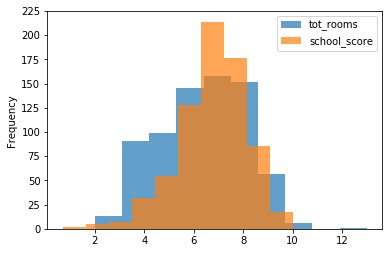

In [27]:
# Plot Hist Map
axes = df.tot_rooms.plot.hist(alpha=0.7)
axes = df.school_score.plot.hist(alpha=0.7)
plt.legend(labels=["tot_rooms", "school_score"])


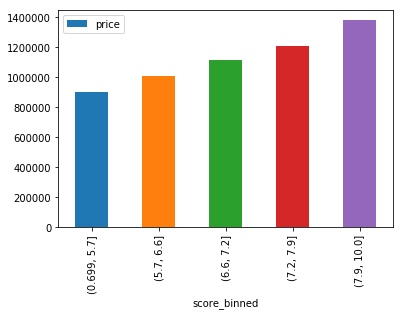

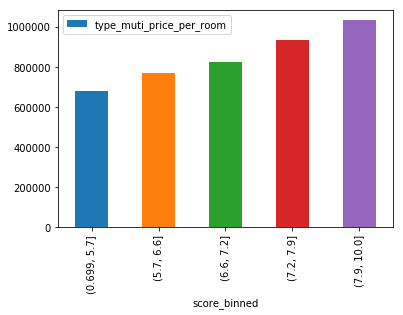

In [28]:
for feature in ["price", "type_muti_price_per_room"]:
    df.loc[:, ["score_binned", feature]].groupby(
        "score_binned"
    ).mean().reset_index().plot.bar(x="score_binned", y=feature)


### Optional: Acquire latitude/longitude coordinates of each neighborhood through Google API

In [29]:
# lat = []
# lng = []
# post_code_responsed = []
# postcode_no_response = []
# key = "" #please input your google api key
# for postcode in df.post_code:
#     URL = "https://maps.googleapis.com/maps/api/geocode/json?address={},+Toronto,+CA&key={}".format(
#     postcode,key
# )

#     # Do the request and get the response data
#     try:
#         req = requests.get(URL)
#         res = req.json()
#         result = res['results'][0]
#         lat.append(result['geometry']['location']['lat'])
#         lng.append(result['geometry']['location']['lng'])
#         post_code_responsed.append(postcode)
#         print(postcode, "finished")
#     except:
#         print(postcode, "google API response no result")
#         postcode_no_response.append(0)
    

In [30]:
# lat_lng = pd.DataFrame([post_code_responsed, lat, lng]).T
# lat_lng.columns = ['post_code', 'lat', 'lng']
# lat_lng.to_csv("lat_lng.csv", header=['post_code', 'lat', 'lng'])
# lat_lng.head()


### 2.3 Acquire Venues data through Foursquare

Use geopy library to get the latitude and longitude values of Toronto.

In [31]:
address = "Toronto, Canada"

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("The geograpical coordinate of Toronto are {}, {}.".format(latitude, longitude))


The geograpical coordinate of Toronto are 43.653963, -79.387207.


Define Foursquare Credentials and Version

In [32]:
CLIENT_ID = ""  # please input your Foursquare ID
CLIENT_SECRET = ""  # please input your Foursquare Secret
VERSION = "20180605"  # Foursquare API version


In [33]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row["categories"]
    except:
        categories_list = row["venue.categories"]

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]["name"]


Acquire the top 300 venues that are in this location within a radius of 1000 meters.

In [34]:
LIMIT = 300  # limit of number of venues returned by Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=1000):

    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT
        )

        # make the GET request
        try:
            results = requests.get(url).json()["response"]["groups"][0]["items"]
        except:
            print("can't get request results from url")

        # return only relevant information for each nearby venue
        venues_list.append(
            [
                (
                    name,
                    lat,
                    lng,
                    v["venue"]["name"],
                    v["venue"]["location"]["lat"],
                    v["venue"]["location"]["lng"],
                    v["venue"]["categories"][0]["name"],
                )
                for v in results
            ]
        )

    nearby_venues = pd.DataFrame(
        [item for venue_list in venues_list for item in venue_list]
    )
    nearby_venues.columns = [
        "Neighborhood",
        "Neighborhood Latitude",
        "Neighborhood Longitude",
        "Venue",
        "Venue Latitude",
        "Venue Longitude",
        "Venue Category",
    ]

    return nearby_venues


In [35]:
# # Run the above function on each post code and create a new dataframe called toronto_venues.
# toronto_venues = getNearbyVenues(
#     names=neighborhoods["post_code"],
#     latitudes=neighborhoods["latitude"],
#     longitudes=neighborhoods["longitude"],
#     radius=1000,
# )

# toronto_venues.to_csv("toronto_venues_1000.csv")



#### Read toronto_venues_1000 dataset from csv

In [36]:
toronto_venues = pd.read_csv("toronto_venues_1000.csv", encoding="ISO-8859-1").iloc[
    :, 1:
]


#### Manipulate Venues Data

In [37]:
toronto_venues["post_code"] = toronto_venues.Neighborhood
venues_cnt = toronto_venues.groupby("post_code").count().Venue.reset_index()
venues_cnt.columns = ["post_code", "Venue_cnt"]
toronto_venues = toronto_venues.merge(venues_cnt, on="post_code")

print(
    "There are {} uniques categories.".format(
        len(toronto_venues["Venue Category"].unique())
    )
)

s = (
    toronto_venues["Venue Category"].value_counts() >= 3
)  # Drop Categories with only 1-2 records
i = s[s == True].index
toronto_venues = toronto_venues[toronto_venues["Venue Category"].isin(i)]

print(
    "There are {} uniques categories after filter.".format(
        len(toronto_venues["Venue Category"].unique())
    )
)


There are 400 uniques categories.
There are 314 uniques categories after filter.


In [38]:
toronto_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,post_code,Venue_cnt
0,M2N2V4,43.759909,-79.396619,Maryam Hotel,43.766961,-79.401199,Hotel,M2N2V4,202
1,M2N2V4,43.759909,-79.396619,Rain Spa & Salon,43.765867,-79.392411,Spa,M2N2V4,202
2,M2N2V4,43.759909,-79.396619,Wimpy's Diner,43.763971,-79.398868,Diner,M2N2V4,202
3,M2N2V4,43.759909,-79.396619,Rexall,43.764621,-79.397718,Pharmacy,M2N2V4,202
4,M2N2V4,43.759909,-79.396619,Moksha Yoga North York,43.763206,-79.404930,Yoga Studio,M2N2V4,202


In [39]:
# one hot encoding
toronto_onehot = pd.get_dummies(
    toronto_venues[["Venue Category"]], prefix="", prefix_sep=""
)

# add neighborhood column back to dataframe
toronto_onehot["Neighborhood"] = toronto_venues["post_code"]

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()


,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Beer Bar,Beer Store,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,CafÃ©,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,

In [40]:
toronto_onehot.shape


(18327, 314)

### 2.4 Group all data into one dataset

group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [41]:
toronto_grouped = toronto_onehot.groupby("Neighborhood").mean().reset_index()
toronto_grouped.shape


(620, 314)

In [42]:
toronto_grouped.rename({"Neighborhood": "post_code"}, axis=1, inplace=True)
toronto_grouped.head()


,post_code,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Beer Bar,Beer Store,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,CafÃ©,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Sze

In [43]:
df_total = df.merge(toronto_grouped, on="post_code")
cnt = toronto_venues.loc[:, ["post_code", "Venue_cnt"]]
cnt.drop_duplicates(inplace=True)
df_total = df_total.merge(cnt, on="post_code")
print(df_total.shape)
df_total.head()


(700, 329)


,city,neighborhood,post_code,school_score,num_bedroom,num_bathroom,price,price_per_room,latitude,longitude,ptype,size,type_muti_price_per_room,tot_rooms,score_binned,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Beer Bar,Beer Store,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,CafÃ©,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods

## 3. Methodology <a name="methodology"></a>

In this project, we will use regression methods to **predict the housing price of different zones**. Since there's only 700 examples but 329 features. Here's the methodologies going through:

First, **dimensionality reduction** using the **correlation matrix** to filter features to avoid the sparse issue of the training set.

Second, **remove the outliers** due to the typo of the website, or the special case, which will have negative impacts on our model performance.

The third step, I'd like to use the K-Means clustering method and folium create a map of the GTA area to explore the basic **clusters distribution** of zones.

The fourth step, **Data Analysis & Visualization**, so we can picture the impacts of different features on the prices.

The fifth step, Machine Learning Modeling, I'll use different **regression models** and **grid search** methods to find the best hyper-parameters of each model and looking into their performance and confirm if that works well.

At last, I'll **compare the performances** among different methods and drop some ideas on **how to improve the accuracy** of our prediction in the future.

### 3.1 Create correlation matrix

In [44]:
cols = list(df_total.columns)
cols = [
    x
    for x in cols
    if x
    not in [
        "city",
        "neighborhood",
        "post_code",
        "latitude",
        "longitude",
        "score_binned",
    ]
]
coef = np.corrcoef(df_total[cols].values.T)
coef_matrix = pd.DataFrame(coef, columns=cols, index=cols)
coef_matrix.head()


,school_score,num_bedroom,num_bathroom,price,price_per_room,ptype,size,type_muti_price_per_room,tot_rooms,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Beer Bar,Beer Store,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,CafÃ©,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationer

### 3.2 Remove the outliers 

In [45]:
print(len(coef_matrix))
print(len(coef_matrix[abs(coef_matrix.price) > 0.1]))


323
36


In [46]:
useful_features = coef_matrix[abs(coef_matrix.price) > 0.1].index
useful_features = list(useful_features)


In [47]:
# drop outliers
print(len(df_total))
df_total = df_total[(df_total.price > 2 * 10 ** 5) & (df_total.price < 2.8 * 10 ** 6)]
df_total = df_total[df_total.post_code != "L1K0S1"]
print(len(df_total))


700
679


### 3.3 Explore the clusters distribution of different zones

In [48]:
df_clusters = df_total.loc[:, useful_features + ["latitude", "longitude"]]
# df_clusters.drop('score_binned',axis=1,inplace=True)
df_clusters.head()

# Standard processing
sc = StandardScaler()
df_clusters_standard = sc.fit_transform(df_clusters)
df_clusters_standard = pd.DataFrame(df_clusters_standard)
df_clusters_standard.columns = df_clusters.columns
df_clusters_standard.head()


C:\Users\zhunqiang\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\zhunqiang\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,school_score,num_bedroom,num_bathroom,price,price_per_room,ptype,size,type_muti_price_per_room,tot_rooms,Baby Store,Bagel Shop,Boutique,Bus Stop,Candy Store,Chinese Restaurant,Chocolate Shop,Deli / Bodega,Fast Food Restaurant,French Restaurant,Garden,Grocery Store,Intersection,Italian Restaurant,Japanese Restaurant,Kids Store,Lawyer,Middle Eastern Restaurant,Office,Pie Shop,Pizza Place,Pool,Salad Place,Sandwich Place,Theme Restaurant,Vegetarian / Vegan Restaurant,Venue_cnt,latitude,longitude
0,2.369399,-1.780133,-1.333995,-0.519449,0.945405,-1.656258,-1.484523,-0.779232,-1.619650,-0.090905,-0.176332,-0.140686,-0.286162,-0.118837,-0.234985,-0.102551,-0.207765,0.136754,-0.220433,-0.104128,-0.309103,0.983083,0.131498,2.754252,-0.150628,-0.053805,1.424099,-0.05435,-0.054346,-0.283488,0.443986,-0.053269,-0.041733,-0.085391,-0.154582,4.718702,-0.134114,0.196415
1,-0.621519,-1.780133,-1.333995,-0.519449,0.945405,-1.656258,-1.484523,-0.779232,-1.619650,-0.090905,-0.176332,-0.140686,-0.286162,-0.118837,-0.234985,-0.102551,-0.207765,0.136754,-0.220433,-0.104128,-0.309103,0.983083,0.131498,2.754252,-0.150628,-0.053805,1.424099,-0.05435,-0.054346,-0.283488,0.443986,-0.053269,-0.041733,-0.085391,-0.154582,4.718702,-0.134114,0.196415
2,2.369399,-1.523141,-1.117096,-1.494375,-1.339410,-1.656258,-1.569000,-1.451144,-1.371943,-0.090905,-0.176332,-0.140686,-0.286162,-0.118837,-0.227903,-0.102551,-0.207765,-0.489713,-0.220433,-0.104128,0.321952,-0.231505,-0.157717,-0.379811,-0.150628,-0.053805,-0.313040,-0.05435,-0.054346,-0.428050,-0.135008,-0.053269,-0.566036,-0.085391,-0.154582,1.888535,18.124340,-11.659326
3,2.369399,0.121606,-0.770057,-0.816807,-1.042380,-0.438390,-0.352065,-0.918280,-0.381112,-0.090905,-0.176332,-0.140686,-0.286162,-0.118837,2.719849,-0.102551,-0.207765,-0.489713,-0.220433,-0.104128,-0.709384,-0.231505,-0.465199,1.675646,-0.150628,-0.053805,-0.313040,-0.05435,-0.054346,0.541356,-0.135008,-0.053269,1.604031,-0.085391,-0.154582,-0.275710,-0.225109,0.113670
4,2.369399,0.943980,0.965134,1.102863,0.511371,0.779478,1.144124,0.898005,1.006050,-0.090905,-0.176332,-0.140686,-0.286162,-0.118837,2.871572,-0.102551,-0.207765,-0.489713,-0.220433,-0.104128,-0.709384,-0.231505,-0.465199,-0.379811,-0.150628,-0.053805,-0.313040,-0.05435,-0.054346,-0.920210,-0.135008,-0.053269,-0.840412,-0.085391,-0.154582,-0.691911,0.066861,0.217310


In [49]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusters_standard)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
df_clusters_standard.insert(0, "Cluster Labels", kmeans.labels_)
df_clusters_standard.head()


,Cluster Labels,school_score,num_bedroom,num_bathroom,price,price_per_room,ptype,size,type_muti_price_per_room,tot_rooms,Baby Store,Bagel Shop,Boutique,Bus Stop,Candy Store,Chinese Restaurant,Chocolate Shop,Deli / Bodega,Fast Food Restaurant,French Restaurant,Garden,Grocery Store,Intersection,Italian Restaurant,Japanese Restaurant,Kids Store,Lawyer,Middle Eastern Restaurant,Office,Pie Shop,Pizza Place,Pool,Salad Place,Sandwich Place,Theme Restaurant,Vegetarian / Vegan Restaurant,Venue_cnt,latitude,longitude
0,3,2.369399,-1.780133,-1.333995,-0.519449,0.945405,-1.656258,-1.484523,-0.779232,-1.619650,-0.090905,-0.176332,-0.140686,-0.286162,-0.118837,-0.234985,-0.102551,-0.207765,0.136754,-0.220433,-0.104128,-0.309103,0.983083,0.131498,2.754252,-0.150628,-0.053805,1.424099,-0.05435,-0.054346,-0.283488,0.443986,-0.053269,-0.041733,-0.085391,-0.154582,4.718702,-0.134114,0.196415
1,3,-0.621519,-1.780133,-1.333995,-0.519449,0.945405,-1.656258,-1.484523,-0.779232,-1.619650,-0.090905,-0.176332,-0.140686,-0.286162,-0.118837,-0.234985,-0.102551,-0.207765,0.136754,-0.220433,-0.104128,-0.309103,0.983083,0.131498,2.754252,-0.150628,-0.053805,1.424099,-0.05435,-0.054346,-0.283488,0.443986,-0.053269,-0.041733,-0.085391,-0.154582,4.718702,-0.134114,0.196415
2,2,2.369399,-1.523141,-1.117096,-1.494375,-1.339410,-1.656258,-1.569000,-1.451144,-1.371943,-0.090905,-0.176332,-0.140686,-0.286162,-0.118837,-0.227903,-0.102551,-0.207765,-0.489713,-0.220433,-0.104128,0.321952,-0.231505,-0.157717,-0.379811,-0.150628,-0.053805,-0.313040,-0.05435,-0.054346,-0.428050,-0.135008,-0.053269,-0.566036,-0.085391,-0.154582,1.888535,18.124340,-11.659326
3,3,2.369399,0.121606,-0.770057,-0.816807,-1.042380,-0.438390,-0.352065,-0.918280,-0.381112,-0.090905,-0.176332,-0.140686,-0.286162,-0.118837,2.719849,-0.102551,-0.207765,-0.489713,-0.220433,-0.104128,-0.709384,-0.231505,-0.465199,1.675646,-0.150628,-0.053805,-0.313040,-0.05435,-0.054346,0.541356,-0.135008,-0.053269,1.604031,-0.085391,-0.154582,-0.275710,-0.225109,0.113670
4,1,2.369399,0.943980,0.965134,1.102863,0.511371,0.779478,1.144124,0.898005,1.006050,-0.090905,-0.176332,-0.140686,-0.286162,-0.118837,2.871572,-0.102551,-0.207765,-0.489713,-0.220433,-0.104128,-0.709384,-0.231505,-0.465199,-0.379811,-0.150628,-0.053805,-0.313040,-0.05435,-0.054346,-0.920210,-0.135008,-0.053269,-0.840412,-0.085391,-0.154582,-0.691911,0.066861,0.217310


In [50]:
# import matplotlib.cm as cm
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
    df_clusters["latitude"],
    df_clusters["longitude"],
    df_clusters_standard["school_score"],
    df_clusters_standard["Cluster Labels"],
):
    label = folium.Popup(str(poi) + " Cluster " + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.7,
    ).add_to(map_clusters)

map_clusters


## 4. Data Analysis & Visualization <a name="Analysis&Visualization"></a>

Now, let's perform some basic explanatory data analysis and use Data Visualization method to determine some relationships between cleaned features and prices.

### 4.1 Use seaborn to plot heatmap

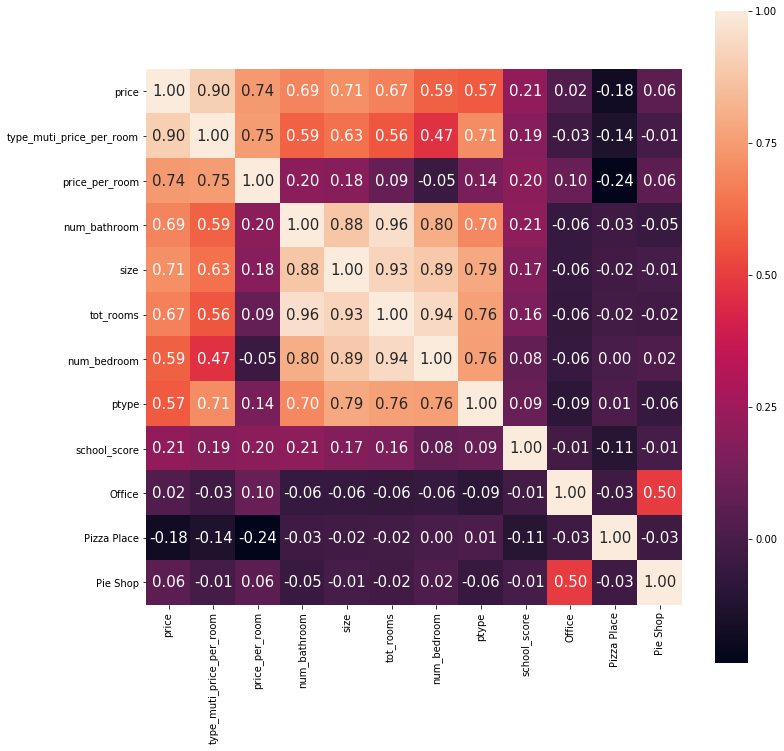

In [51]:
cols = coef_matrix.iloc[(-np.abs(coef_matrix["price"].values)).argsort()].index[:12]

coef = np.corrcoef(df_total[cols].values.T)
fig, ax = plt.subplots(figsize=(12, 12))  # Sample figsize in inches
hm = sns.heatmap(
    coef,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 15},
    yticklabels=cols,
    xticklabels=cols,
    ax=ax,
)


### 4.2 Plot scatter_matrix

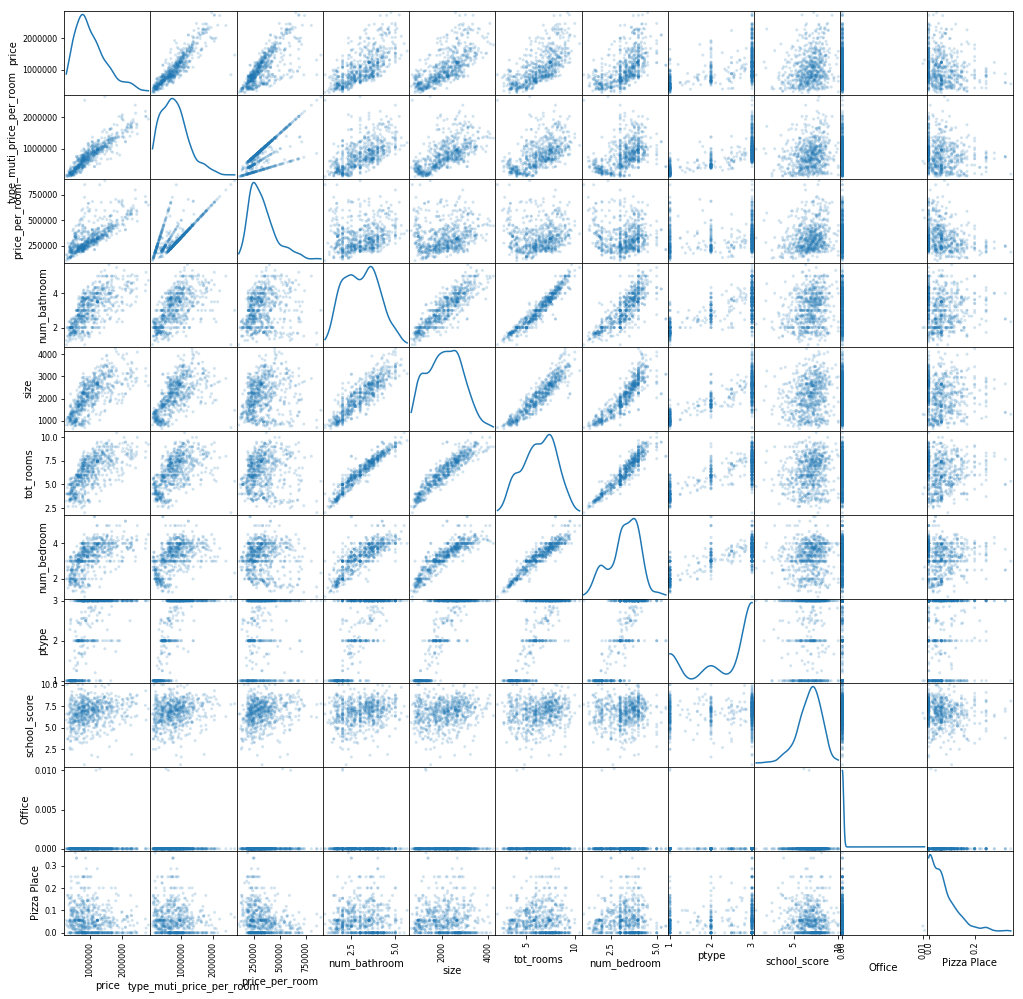

In [52]:
from pandas.plotting import scatter_matrix

cols = coef_matrix.iloc[(-np.abs(coef_matrix["price"].values)).argsort()].index[:11]
scatter_matrix = scatter_matrix(
    df_total[cols], alpha=0.2, figsize=(17, 17), diagonal="kde"
)


### 4.3 Use binning method and matplotlib to plot some bar graphs

In [53]:
temp = df_total
temp["price_binned"] = pd.qcut(
    temp["price"], 5, labels=["very low", "low", "medium", "high", "very high"]
)
temp.price_binned.value_counts()


very high    136
high         136
low          136
very low     136
medium       135
Name: price_binned, dtype: int64

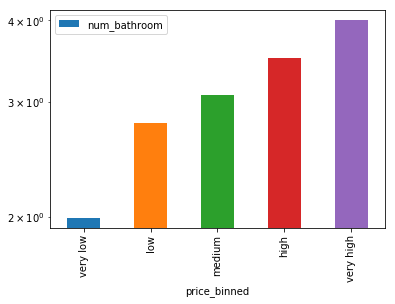

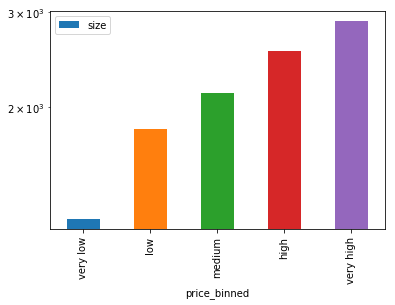

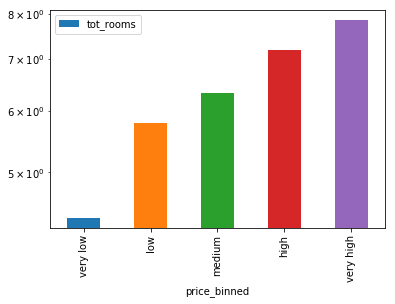

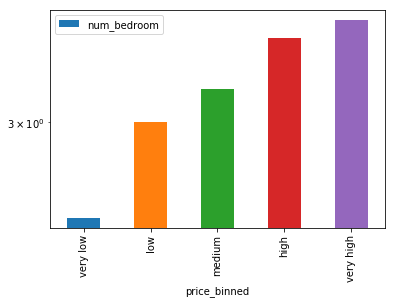

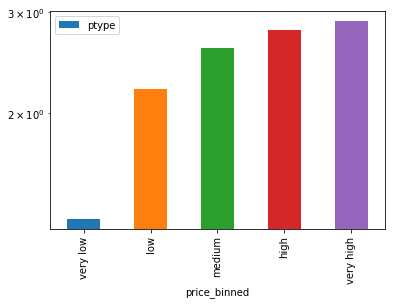

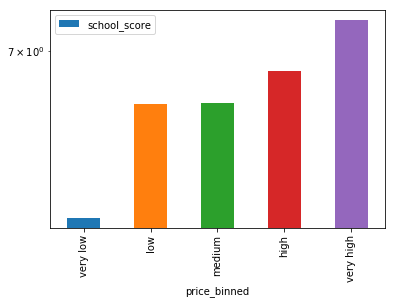

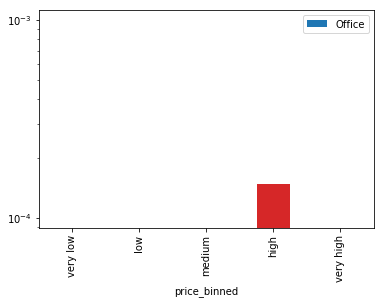

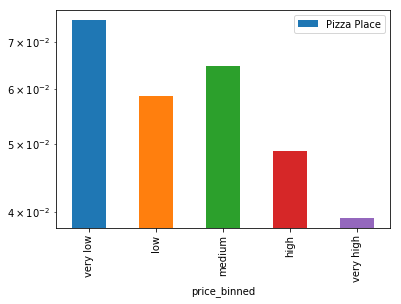

In [54]:
for feature in cols[3:]:
    temp.loc[:, ["price_binned", feature]].groupby(
        "price_binned"
    ).mean().reset_index().plot.bar(x="price_binned", y=feature, logy=True)


## 5. Modeling <a name="Modeling"></a>

### 5.1 Create Training/Testing Datasets and Performance Record Dataframe

In [55]:
# Create features and label
features = [
    "school_score",
    "num_bedroom",
    "num_bathroom",
    "ptype",
    "size",
] + useful_features[9:]
X = df_total.loc[:, features]
y = df_total.loc[:, "price"]

# Split data into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Create a dataframe to store the performance of each models
scores = pd.DataFrame()


### 5.2 Create Predict and Plot function for different Machine Learning Methods

In [56]:
# Create Predict and Plot function for ML methods
def try_different_method(method):
    method.fit(X_train, y_train)
    y_pred = method.predict(X_test)

    y_test_temp = y_test.reset_index(drop=True)
    order = y_pred.argsort(axis=0)
    y_pred = y_pred[order]
    y_test_temp = y_test_temp[order]

    #     maer = np.mean(abs(y_pred - y_test_temp) / y_test_temp)
    mse = metrics.mean_squared_error(y_test_temp, y_pred)
    r2 = metrics.r2_score(y_test_temp, y_pred)

    plt.figure(figsize=(10, 6))
    plt.plot(
        np.arange(len(y_pred)),
        y_test_temp,
        "ro",
        markersize=4,
        label="list price",
        alpha=0.5,
    )
    plt.plot(
        np.arange(len(y_pred)),
        y_pred,
        "bo-",
        markersize=4,
        label="predict price",
        alpha=0.9,
    )

    plt.grid()
    plt.title("MSE: %f" % mse)
    print("mean_squared_error: %f" % mse)
    print("r2: %f" % r2)
    #     print('mean_abs_error_rate: %f' % maer)
    plt.legend()
    return (r2, mse)


### 5.3 Random Forest algorithm

#### Use GridSearch method for Random Forest to figure the best hyper-parameters

In [57]:
# parameters to search over with cross-validation
grid_params = [
    {
        "n_estimators": [10, 50, 100],
        "max_depth": [3, 6, 8, 10, None],
        "min_samples_leaf": [1, 2, 5],
    }
]

clf = GridSearchCV(RandomForestRegressor(), grid_params, cv=5, scoring="r2", n_jobs=2)
clf.fit(X_train, y_train)

print("Best parameter values: %r\n" % clf.best_params_)


Best parameter values: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}



#### Use try_different_method function to plot prediction graph

mean_squared_error: 72769681045.022034
r2: 0.711886


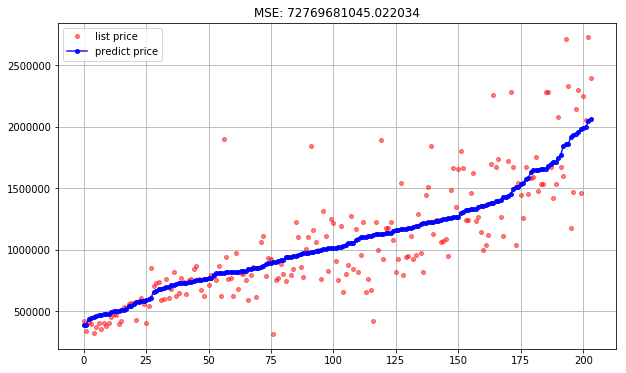

In [58]:
# RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=clf.best_params_["n_estimators"],
    criterion="mse",
    max_depth=clf.best_params_["max_depth"],
    min_samples_leaf=clf.best_params_["min_samples_leaf"],
    n_jobs=2,
    random_state=None,
)

performance_rf = try_different_method(rf)

scores.loc[0, "Random Forest"] = performance_rf[0]
scores.loc[1, "Random Forest"] = performance_rf[1]


#### Plot Feature Importance graph

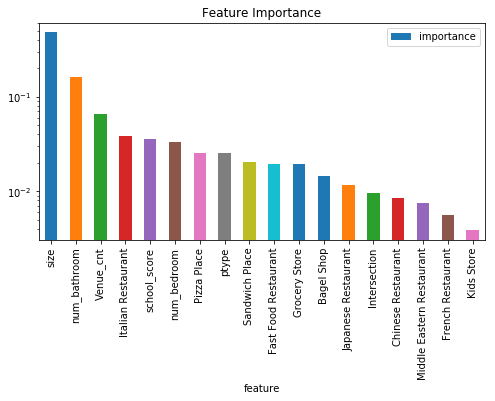

In [59]:
importance = pd.DataFrame({"feature": features, "importance": rf.feature_importances_})
importance.sort_values(by="importance", axis=0, ascending=False, inplace=True)
importance[:18].plot(
    x="feature",
    y="importance",
    kind="bar",
    figsize=(8, 4),
    title="Feature Importance",
    logy=True,
)


### 5.4 Decision Tree algorithm

#### Use GridSearch method to figure the best hyper-parameters

In [60]:
# parameters to search over with cross-validation
grid_params = [{"max_depth": [3, 4, 5, 6, 8, None], "min_samples_leaf": [1, 2, 5, 7]}]

tree = GridSearchCV(DecisionTreeRegressor(), grid_params, cv=5, scoring="r2", n_jobs=2)
tree.fit(X_train, y_train)

print("Best parameter values: %r\n" % tree.best_params_)


Best parameter values: {'max_depth': 4, 'min_samples_leaf': 7}



#### Use try_different_method function to plot prediction graph

mean_squared_error: 104427983981.535675
r2: 0.586543


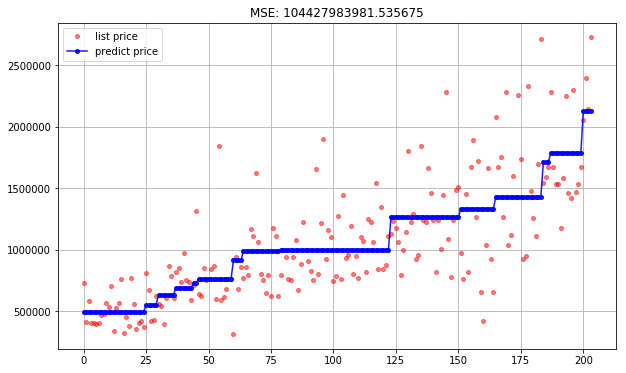

In [61]:
# RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(
    max_depth=tree.best_params_["max_depth"],
    min_samples_leaf=tree.best_params_["min_samples_leaf"],
    random_state=None,
)

performance_tree = try_different_method(tree)
scores.loc[0, "Decistion Tree"] = performance_tree[0]
scores.loc[1, "Decistion Tree"] = performance_tree[1]


#### Use Graphviz Create a Decision Tree Graph

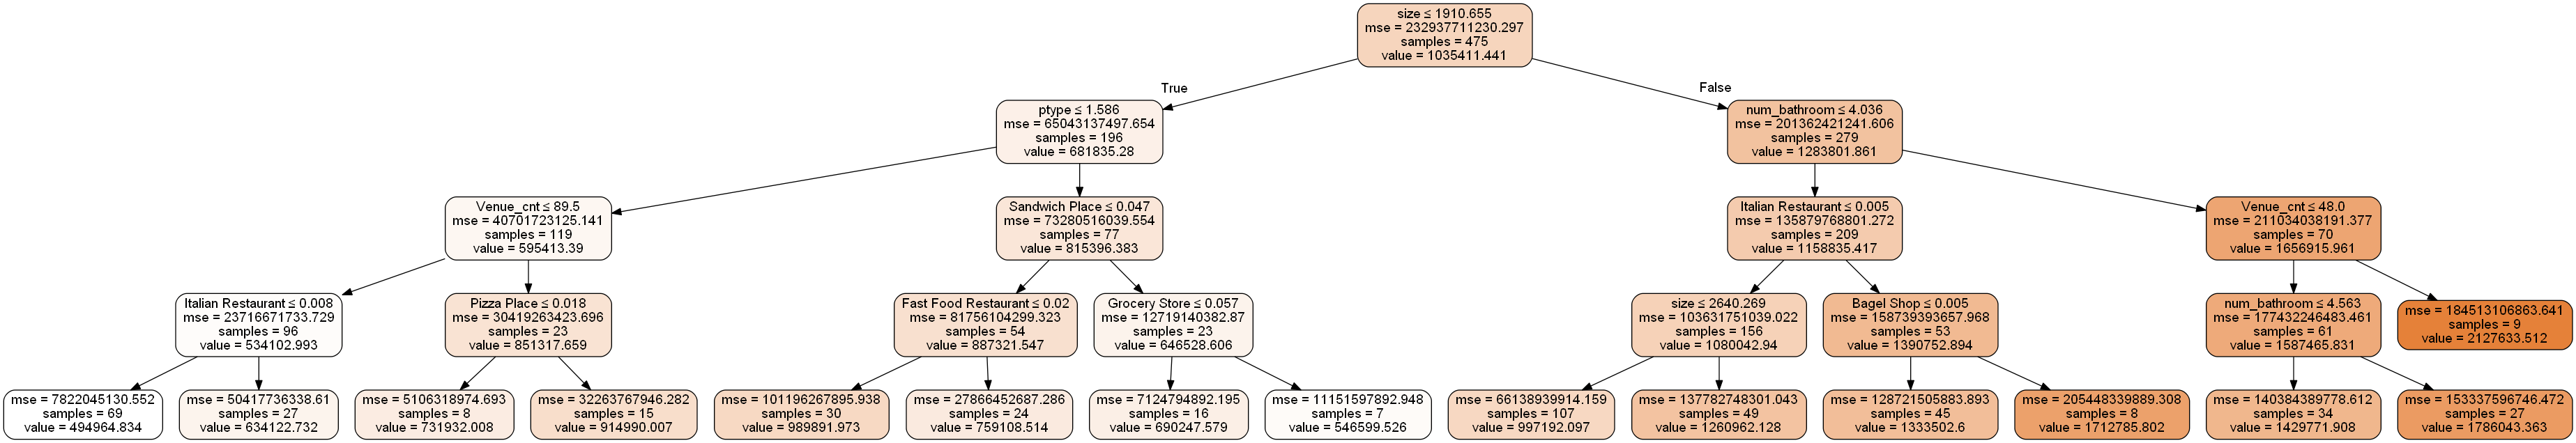

In [62]:
dot_data = StringIO()
export_graphviz(
    tree,
    out_file=dot_data,
    feature_names=features,
    #                 class_names=['Churn'],
    filled=True,
    rounded=True,
    leaves_parallel=False,
    rotate=False,
    special_characters=True,
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_pdf("tree_vehicles.pdf")  # this line saves the diagram to a pdf file
Image(graph.create_png())


### 5.5 XGBoost Regressor algorithm

#### Use GridSearch method to figure the best hyper-parameters

In [63]:
# parameters to search over with cross-validation
grid_params = [
    {
        "max_depth": [3, 4, 5],
        "learning_rate": [0.01, 0.1, 1],
        "n_estimators": [10, 50],
        "reg_lambda": [10, 1, 0.1, 0.01],
        "objective": ["reg:linear"],
    }
]

xgbr = GridSearchCV(xgb.XGBRegressor(), grid_params, cv=5, scoring="r2", n_jobs=2)
xgbr.fit(X_train, y_train)

print("Best parameter values: %r\n" % xgbr.best_params_)


Best parameter values: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'objective': 'reg:linear', 'reg_lambda': 1}



#### Use try_different_method function to plot prediction graph

mean_squared_error: 76975095106.202652
r2: 0.695236


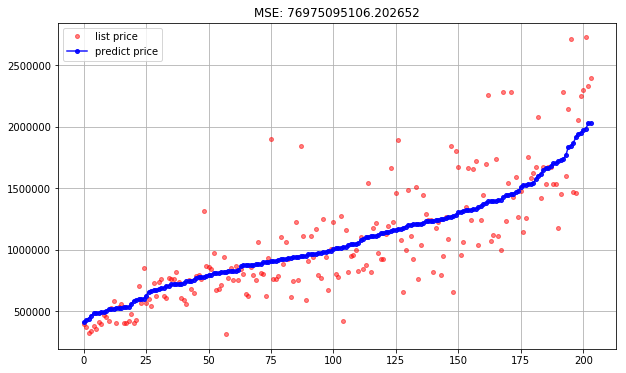

In [64]:
xgbr = xgb.XGBRegressor(
    max_depth=xgbr.best_params_["max_depth"],
    learning_rate=xgbr.best_params_["learning_rate"],
    n_estimators=xgbr.best_params_["n_estimators"],
    reg_lambda=xgbr.best_params_["reg_lambda"],
    n_jobs=2,
)

performance_XGB = try_different_method(xgbr)
scores.loc[0, "XGBoost"] = performance_XGB[0]
scores.loc[1, "XGBoost"] = performance_XGB[1]


#### Plot Feature Importance graph

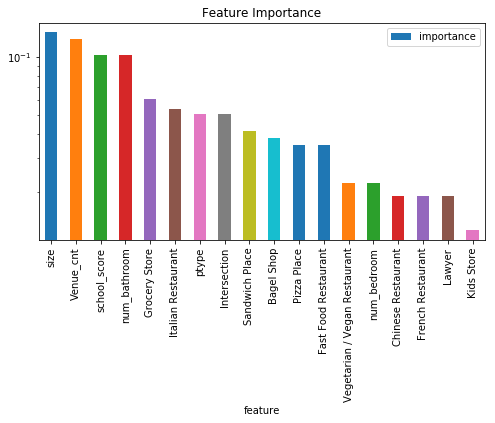

In [65]:
importance = pd.DataFrame(
    {"feature": features, "importance": xgbr.feature_importances_}
)
importance.sort_values(by="importance", axis=0, ascending=False, inplace=True)
importance[:18].plot(
    x="feature",
    y="importance",
    kind="bar",
    figsize=(8, 4),
    title="Feature Importance",
    logy=True,
)


### 5.5 KNN algorithm

In [66]:
# Standard processing
sc = StandardScaler()
X_standard = sc.fit_transform(X)
X_standard = pd.DataFrame(X_standard)
X_standard.columns = X.columns
X_standard.head()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)  # , random_state=42


C:\Users\zhunqiang\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\zhunqiang\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#### Use GridSearch method to figure the best hyper-parameters

In [67]:
# parameters to search over with cross-validation
grid_params = [{"n_neighbors": [i for i in range(1, 10)]}]

knn = GridSearchCV(
    neighbors.KNeighborsRegressor(), grid_params, cv=5, scoring="r2", n_jobs=2
)
knn.fit(X_train, y_train)

print("Best parameter values: %r\n" % knn.best_params_)


Best parameter values: {'n_neighbors': 5}



#### Use try_different_method function to plot prediction graph

mean_squared_error: 130861857007.723038
r2: 0.481884


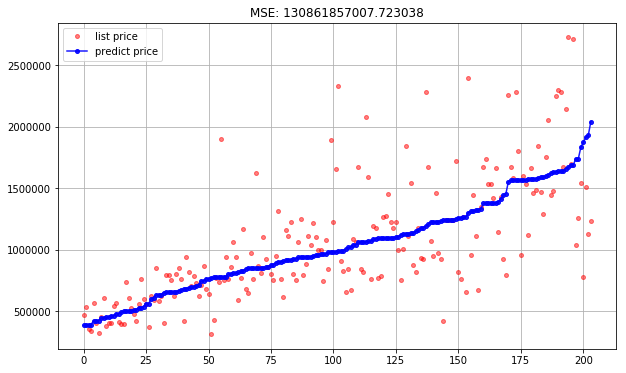

In [68]:
knn = neighbors.KNeighborsRegressor(
    n_neighbors=knn.best_params_["n_neighbors"], n_jobs=2
)

performance_KNN = try_different_method(knn)
scores.loc[0, "KNN"] = performance_KNN[0]
scores.loc[1, "KNN"] = performance_KNN[1]


### 5.6 Use Keras deploy Nural networks

In [69]:
# Standard processing
sc = StandardScaler()
X_standard = sc.fit_transform(X)
X_standard = pd.DataFrame(X_standard)
X_standard.columns = X.columns
X_standard.head()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)  # , random_state=42


C:\Users\zhunqiang\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\zhunqiang\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [70]:
a = 100
drop = 0.1
n = len(features)

model = Sequential(
    [
        Dense(
            int(n * 1.2), input_dim=n, kernel_initializer="normal", activation="relu"
        ),
        Dropout(drop),
        Dense(int(n), kernel_initializer="normal", activation="linear"),
        Dropout(drop),
        Dense(
            int(n * 0.5),
            activation="linear",
            kernel_regularizer=regularizers.l1_l2(l1=a, l2=a),
        ),
        Dropout(drop),
        Dense(1, kernel_initializer="normal"),
    ]
)


In [71]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 38)                1254      
_________________________________________________________________
dropout_1 (Dropout)          (None, 38)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1248      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

In [72]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error", "mae", "mape"],
)
history = model.fit(
    X_train, y_train, validation_split=0.2, epochs=50, verbose=1, shuffle=True
)  # batch_size=len(X_train), shuffle=True


Train on 380 samples, validate on 95 samples
Epoch 1/50
380/380 [==============================] - 1s 3ms/step - loss: 1296863442060.1262 - mean_squared_error: 1296863442060.1262 - mean_absolute_error: 1031419.8270 - mean_absolute_percentage_error: 99.9981 - val_loss: 1337353394413.1370 - val_mean_squared_error: 1337353394413.1370 - val_mean_absolute_error: 1051263.7697 - val_mean_absolute_percentage_error: 99.9959
Epoch 2/50
380/380 [==============================] - 0s 103us/step - loss: 1296744641158.7368 - mean_squared_error: 1296744641158.7368 - mean_absolute_error: 1031367.5454 - mean_absolute_percentage_error: 99.9926 - val_loss: 1337152430683.6211 - val_mean_squared_error: 1337152430683.6211 - val_mean_absolute_error: 1051178.7724 - val_mean_absolute_percentage_error: 99.9872
Epoch 3/50
380/380 [==============================] - 0s 100us/step - loss: 1296423327118.8210 - mean_squared_error: 1296423327118.8210 - mean_absolute_error: 1031229.1500 - mean_absolute_percentage_error:

Epoch 23/50
380/380 [==============================] - 0s 90us/step - loss: 151269193533.9789 - mean_squared_error: 151269157747.8737 - mean_absolute_error: 282937.6974 - mean_absolute_percentage_error: 28.0817 - val_loss: 92119133561.2632 - val_mean_squared_error: 92119092601.2632 - val_mean_absolute_error: 220218.6372 - val_mean_absolute_percentage_error: 21.8687
Epoch 24/50
380/380 [==============================] - 0s 92us/step - loss: 138546486347.4526 - mean_squared_error: 138546450216.4211 - mean_absolute_error: 278879.3546 - mean_absolute_percentage_error: 27.6731 - val_loss: 92430832262.7368 - val_mean_squared_error: 92430791302.7368 - val_mean_absolute_error: 219620.4730 - val_mean_absolute_percentage_error: 21.6771
Epoch 25/50
380/380 [==============================] - 0s 85us/step - loss: 147230423794.5263 - mean_squared_error: 147230388353.3474 - mean_absolute_error: 286662.3104 - mean_absolute_percentage_error: 28.7083 - val_loss: 93289099479.5789 - val_mean_squared_error

380/380 [==============================] - 0s 90us/step - loss: 146868505804.8000 - mean_squared_error: 146868468294.0631 - mean_absolute_error: 283441.2319 - mean_absolute_percentage_error: 28.2315 - val_loss: 92022914554.6105 - val_mean_squared_error: 92022873594.6105 - val_mean_absolute_error: 217556.8319 - val_mean_absolute_percentage_error: 21.3337
Epoch 46/50
380/380 [==============================] - 0s 87us/step - loss: 139276944049.8526 - mean_squared_error: 139276906797.8105 - mean_absolute_error: 280192.1359 - mean_absolute_percentage_error: 28.1733 - val_loss: 92237716296.7579 - val_mean_squared_error: 92237675336.7579 - val_mean_absolute_error: 217215.2641 - val_mean_absolute_percentage_error: 21.2339
Epoch 47/50
380/380 [==============================] - 0s 98us/step - loss: 132074738957.4737 - mean_squared_error: 132074702438.4000 - mean_absolute_error: 271285.7531 - mean_absolute_percentage_error: 27.1437 - val_loss: 92345906143.6632 - val_mean_squared_error: 9234586518

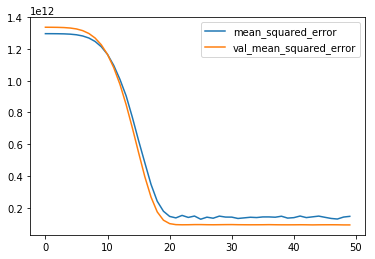

In [73]:
# plot metrics
ax1 = plt.plot(history.history["mean_squared_error"])
ax2 = plt.plot(history.history["val_mean_squared_error"])
plt.legend(["mean_squared_error", "val_mean_squared_error"])


In [74]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_test = np.array(y_test)


In [75]:
def my_r2_score(v_true, v_pred):
    ssres = np.sum(np.square(v_true - v_pred))
    sstot = np.sum(np.square(v_true - np.mean(v_true)))
    return 1 - ssres / (sstot)


In [76]:
print("r2 on Test Set:", r2_score(y_test, y_pred))
print("r2 on Train Set:", r2_score(y_train, y_pred_train))
print("MSE on Test Set:", mean_squared_error(y_test, y_pred))
print("MSE on Train Set:", mean_squared_error(y_train, y_pred_train))
print("MAE on TestSet:", mean_absolute_error(y_test, y_pred))
print("MAE on TrainSet:", mean_absolute_error(y_train, y_pred_train))


r2 on Test Set: 0.5851959770253133
r2 on Train Set: 0.5095797931580266
MSE on Test Set: 104768184044.16441
MSE on Train Set: 114237360522.85742
MAE on TestSet: 238668.88975622566
MAE on TrainSet: 248819.42517589024


mean_squared_error: 104768184044.164429
r2: 0.585196


,Random Forest,Decistion Tree,XGBoost,KNN,Neural network
0,7.118862e-01,5.865429e-01,6.952359e-01,4.818845e-01,5.851960e-01
1,7.276968e+10,1.044280e+11,7.697510e+10,1.308619e+11,1.047682e+11


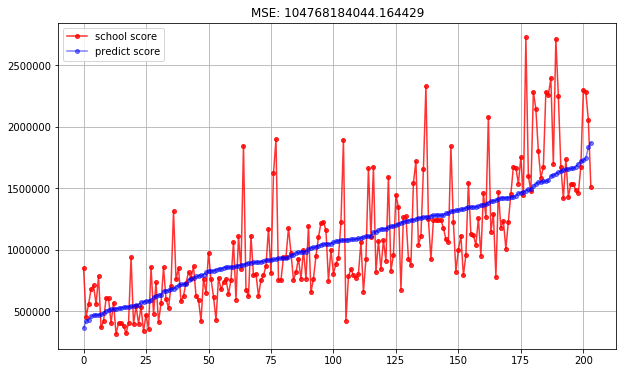

In [77]:
y_pred_temp = np.array([i[0] for i in y_pred])
y_test_temp = y_test  # .reset_index(drop=True)
order = y_pred_temp.argsort(axis=0)
y_pred_temp = y_pred_temp[order]
y_test_temp = y_test_temp[order]


mse_NN = metrics.mean_squared_error(y_test_temp, y_pred_temp)
r2_NN = metrics.r2_score(y_test_temp, y_pred_temp)

plt.figure(figsize=(10, 6))
plt.plot(
    np.arange(len(y_pred_temp)), y_test_temp, "ro-", markersize=4, label="school score", alpha=0.8
)
plt.plot(
    np.arange(len(y_pred_temp)),
    y_pred_temp,
    "bo-",
    markersize=4,
    label="predict score",
    alpha=0.5,
)

plt.grid()
plt.title("MSE: %f" % mse_NN)
print("mean_squared_error: %f" % mse_NN)
print("r2: %f" % r2_NN)
# print('mean_abs_error_rate: %f' % maer)
plt.legend()

scores.loc[0, "Neural network"] = r2_NN
scores.loc[1, "Neural network"] = mse_NN
scores


## 6. Results and Discussion <a name="results"></a>

Based on the R2 and MSE peformace of different methods, we can tell that **Random Forest** and **XGBoost** are the best choices of our case and dataset, althrough the score is limited due to lack of exact size, built year, and other important features.

For the method of the Neural network method, in this project, I've just used some basic functions by Keras for practice and comparison usage. Since the dataset itself is very small, can't work its advantages, the performance only similar to what we have with Decision Tree algorithms. In the real industry, it's only required when we need huge dataset or special business cases.

In [78]:
scores = scores.T
scores.columns = ["R2", "Mean Squared Error"]
scores


,R2,Mean Squared Error
Random Forest,0.711886,7.276968e+10
Decistion Tree,0.586543,1.044280e+11
XGBoost,0.695236,7.697510e+10
KNN,0.481884,1.308619e+11
Neural network,0.585196,1.047682e+11


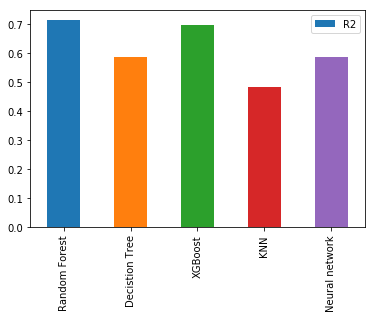

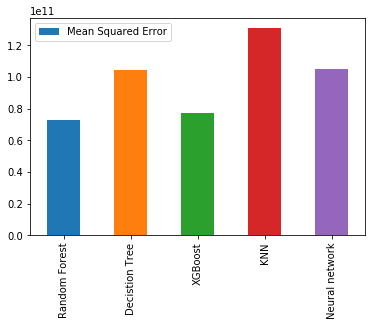

In [80]:
ax1 = scores.plot.bar(y="R2")
ax2 = scores.plot.bar(y="Mean Squared Error")
plt.legend()


## 7. Conclusion <a name="conclusion"></a>

The purpose of this project was using web scraping method and API to collect the related data of GTA including housing, school, Venus. Then use ETL method to get a clean version for analysis/visualization, eventually deploy different machine learning methods both using Skitlearn and Keras.

As we can figure from the performance and analyst. Most of the features do prove there are some correlations between itself and price, especially put them together to get a decent prediction performance. However, as we mentioned, there are so many candidate features I couldn't get so far. Basic on my personal experience and relator business experience, I'm pretty sure we will have much better performance with more official data especially like housing size, land size, built year, management fee, security ranking, income, ages, rental rate, etc.
